# Prediction Intervals

In the previous lecture we have measured the accuracy of our **point forecast**.  

We should always recognise that when we forecast the future there is a degree of uncertainty in our point forecast. If we focus only on point forecasts then we ignore this uncertainty.  

The point forecast we used in the baseline analysis was actually the mean of a **forecast distribution**.  Taking a statistical perspective to forecasting allows us to make inference about our forecast uncertainty via **prediction intervals**.

**In the lecture you will learn**

* The difference between a confidence interval and a prediction interval
* How to generate a prediction interval for baseline forecast methods.
* How to evaluate the accuracy (called coverage) of a prediction interval.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates

import seaborn as sns 
import matplotlib.style as style
style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from forecast_tools.baseline import Naive1, Drift, SNaive

## Helper Functions

In [2]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    preds - numpy.array, vector of predictions
    start - start date of the time series
    freq - the frequency of the time series e.g 'MS' or 'D'
    '''
    start = pd.date_range(start=data.index.max(), periods=2, freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

In [3]:
def plot_prediction_intervals(train, preds, intervals, 
                              test=None):
    '''
    Helper function to plot training data, point preds
    and 2 sets of prediction intevals
    
    assume 2 sets of PIs are provided!
    '''
    ax = train.plot(figsize=(12,4))

    mean = preds_as_series(train, preds)
    intervals_80 = preds_as_series(train, intervals[0])
    intervals_90 = preds_as_series(train, intervals[1])

    mean.plot(ax=ax, label='point forecast')

    ax.fill_between(intervals_80.index, mean[0], intervals_80[1], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,mean[0], intervals_80[0], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,intervals_80[1], intervals_90[1], 
                    alpha=0.2,
                    label='90% PI', color='purple');

    ax.fill_between(intervals_80.index,intervals_80[0], intervals_90[0], 
                    alpha=0.2,
                    label='90% PI', color='purple');
    
    if test is None:
        ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', '90%PI'], loc=2)
    else:
        test.plot(ax=ax, color='black')
        ax.legend(['train', 'point forecast', 'Test', '80%PI', '_ignore','_ignore', '90%PI'], loc=2)
    
    

## Load, train-test split the data for this lecture

In [4]:
url = "https://raw.githubusercontent.com/health-data-science-OR/hpdm097-datasets/master/ed_mth_ts.csv"
ed_month = pd.read_csv(url, index_col='date', parse_dates=True)
ed_month.index.freq='MS'
arrival_rate = ed_month['arrivals'] / ed_month.index.days_in_month

#train test split
train_length = arrival_rate.shape[0] - 12
train, test = arrival_rate.iloc[:train_length], arrival_rate.iloc[train_length:]

## Confidence Intervals Versus Prediction Intervals

Many people are familar with the concept of Confidence Intervals.  However, for forecasting we must use a related but slightly different concept called the prediction interval.

### Confidence Intervals

Imagine you want to estimate the mean height of adults in the UK. You are standing in a room and adults enter one-by-one and you measure and record their heights. After 30 people have visited you calculate their mean height.  This is the sample mean: an estimate of the true population parameter based on a random sample of observations.  As your sample is finite, your estimate is subject to some uncertainty. 

How do you quantify that uncertainty?

This is where confidence interval's (CIs) are used.  If you repeated the experiment 100 times and each time calculated a 95% CI then you would expect 95 of those intervals to contain the true mean height of adults and 5 to not contain it.  A CI therefore provides a statistical estimate of the distribution of the true mean height of the adults if you repeated the experiment many times.|

### Prediction Intervals

Now imagine that you continue the experiment with a slight twist. Your job is to now predict the height of person 31 i.e. the **next person that arrives**.  

To quantify the uncertainty in a individual prediction you must provide an interval with a specified probability.  A Prediction Interval (PI) must account for the uncertainty in estimating the population mean height and the random variation you see with each person.  This means that a 95% PI is much wider than a 95% CI.

The key point is that CIs focus on estimating population parameters from observed data (e.g. mean height) whereas PIs focus on the uncertainty of a prediction of a unobserved future value.


## Uncertainty and forecast horizons

A general rule of thumb is that our forecast accuracy decreases the further into the future we predict.  The more uncertainty in a forecast the wider the prediction interval.

To put it another way the further ahead you forecast the wider a prediction interval.

**Example:**

In [5]:
nf1 = Naive1()
nf1.fit(train)
preds, intervals = nf1.predict(horizon=12, return_predict_int=True, alpha=[0.2, 0.1])

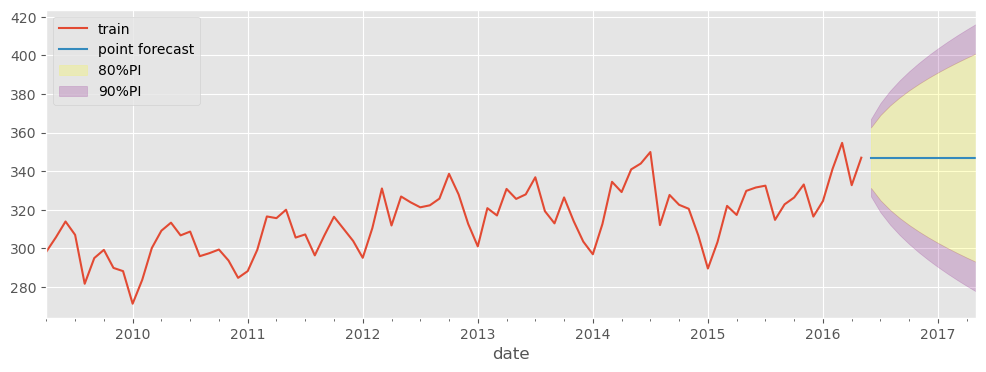

In [6]:
plot_prediction_intervals(train, preds, intervals)

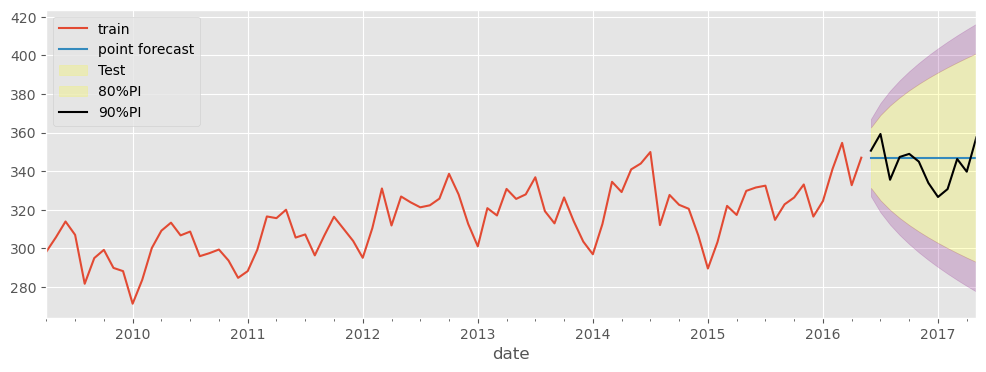

In [7]:
plot_prediction_intervals(train, preds, intervals, test=test)

# Evaluating a predicton interval

In practice, producing a prediction interval that offers the correct level of coverage is tricky. If the model is a poor fit then it will produce PIs that are too wide.  While more complex methods tend to be overconfident and produce intervals that are too narrow.  

In this example we will use the MAE of the point predictions to choose between Naive1 and SNaive.  We will then use the best method to produce PIs and measure their empirical coverage of the test set.

### Load and process the data

In [8]:
url = 'https://raw.githubusercontent.com/health-data-science-OR/hpdm097-datasets/master/Alcohol_Sales.csv'
sales = pd.read_csv(url, index_col='DATE', parse_dates=True)
sales.index.freq = 'MS'
sales_rate = sales['sales'] / sales.index.days_in_month

HORIZON = 12
train = sales_rate.iloc[:len(sales) - HORIZON]
test = sales_rate.iloc[len(sales) - HORIZON:]

#log transform the data
train = np.log(train)

### Fit the models and generate point forecasts

In [9]:
snf = SNaive(period=12)
snf.fit(train)
snf_preds = snf.predict(horizon=HORIZON)

nf1 = Naive1()
nf1.fit(train)
nf1_preds = nf1.predict(horizon=HORIZON)

### Calcluate out of sample MAE

In [10]:
from sklearn.metrics import mean_absolute_error

In [11]:
#back transform the point forecasts
snf_preds = np.exp(snf_preds)
nf1_preds = np.exp(nf1_preds)

In [12]:
#MAE SNaive
mean_absolute_error(y_true=test, y_pred=snf_preds)

22.287192780337975

In [13]:
#MAE Naive1
mean_absolute_error(y_true=test, y_pred=nf1_preds)

56.68657194060406

* Conclusion!  SNaive has the lower MAE

### Get and Plot Prediction Intervals

In [15]:
snf_preds, snf_intervals = snf.predict(horizon=HORIZON, 
                                       return_predict_int=True, 
                                       alpha=[0.2, 0.05])

#back transform the point forecasts
snf_preds = np.exp(snf_preds)
snf_intervals = np.exp(snf_intervals)

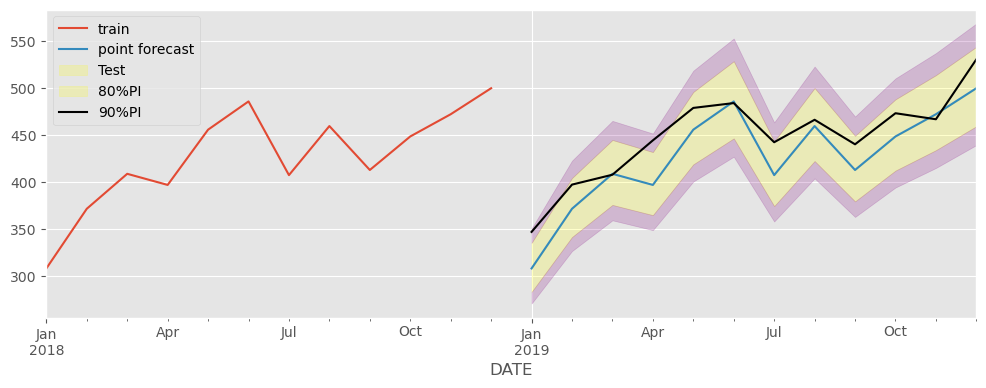

In [16]:
plot_prediction_intervals(np.exp(train[-12:]), snf_preds, snf_intervals, test=test)

### Calculate Coverage

In [17]:
from forecast_tools.metrics import coverage

In [18]:
help(coverage)

Help on function coverage in module forecast_tools.metrics:

coverage(y_true, pred_intervals)
    Prediction Interval Coverage
    
    Calculates the proportion of the true
    values are that are covered by the lower
    and upper bounds of the prediction intervals
    
    Parameters:
    -------
    y_true -- array-like,
        actual observations
    
    pred_intervals -- np.array, matrix (hx2)
        prediction intervals
    
    Returns:
    -------
    float



In [19]:
#80% Predictions intervals
coverage(y_true=test, pred_intervals=snf_intervals[0])

0.8333333333333334

In [20]:
#95% Predictions intervals
coverage(y_true=test, pred_intervals=snf_intervals[1])

1.0